In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle

In [ ]:
def create_autoencoder(input_dim, encoding_dim, dropout_rate):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder



Non-empty counts:
NSP
1    1655
2     295
3     176
Name: count, dtype: int64

Empty count:
0


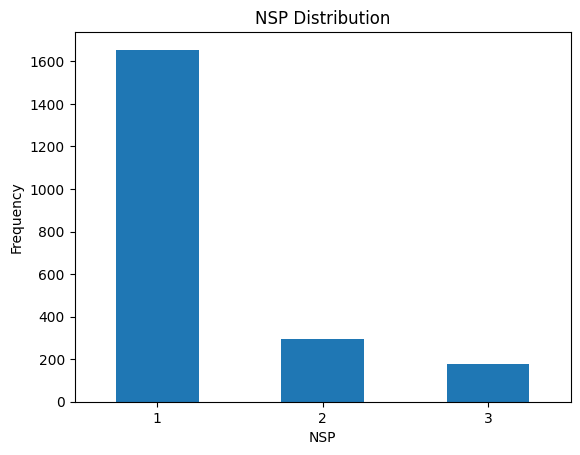

In [ ]:
# Load data
df = pd.read_csv('/content/TF_data.csv')

# Fill missing values in 'NSP' column with the mode
# df['NSP'].fillna(df['NSP'].mode()[0], inplace=True)

# Count occurrences of each value in 'NSP' column
nsp_counts = df['NSP'].value_counts()

# Count missing values (empty count)
empty_count = df['NSP'].isna().sum()

# Display the counts
print("Non-empty counts:")
print(nsp_counts)
print("\nEmpty count:")
print(empty_count)
count_classes = pd.value_counts(df['NSP'], sort = True)

count_classes.plot(kind = 'bar', rot=0)
plt.title("NSP Distribution")
plt.xlabel("NSP")
plt.ylabel("Frequency")

# Remove samples with NSP = 2
df = df[df['NSP'] != 2]



In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Split train set into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Save the labels for the test set
test_labels = test_df['NSP']

# Extract features and labels for train, validation, and test sets
train_normal = train_df[train_df['NSP'] == 1].drop('NSP', axis=1).values
val_normal = val_df[val_df['NSP'] == 1].drop('NSP', axis=1).values
test_normal = test_df[test_df['NSP'] == 1].drop('NSP', axis=1).values

train_labels = train_df['NSP']
val_labels = val_df['NSP']

train_data = train_df.drop('NSP', axis=1).values
val_data = val_df.drop('NSP', axis=1).values
test_data = test_df.drop('NSP', axis=1).values

# Normalize data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

# Shuffle training data
train_data_scaled, train_labels = shuffle(train_data_scaled, train_labels, random_state=42)


In [ ]:
# Define hyperparameters
input_dim = train_data_scaled.shape[1]
learning_rate = 0.03
epochs = 50
batch_size = 32
threshold_fixed = 1.5

# Hyperparameters for tuning
encoding_dims = [8, 16, 32]
dropout_rates = [0.2, 0.3, 0.4]

results = {}

for encoding_dim in encoding_dims:
    for dropout_rate in dropout_rates:
        print(f"Testing encoding_dim={encoding_dim}, dropout_rate={dropout_rate}")

        # Create and train autoencoder
        autoencoder = create_autoencoder(input_dim, encoding_dim, dropout_rate)
        history = autoencoder.fit(train_data_scaled, train_data_scaled,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  validation_data=(val_data_scaled, val_data_scaled),
                                  verbose=0)  # Setting verbose to 0 to suppress output

        # Evaluate model
        test_data_predictions = autoencoder.predict(test_data_scaled)
        mse = np.mean(np.power(test_data_scaled - test_data_predictions, 2), axis=1)

        # Determine anomalies based on the reconstruction error
        anomalies = mse > threshold_fixed

        # Calculate accuracy of anomaly detection
        accuracy = np.mean(anomalies == (test_labels == 3))

        # Store results
        results[(encoding_dim, dropout_rate)] = accuracy

# Find the best hyperparameters
best_params = max(results, key=results.get)
best_accuracy = results[best_params]

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)



Testing encoding_dim=8, dropout_rate=0.2
12/12 [==============================] - 0s 2ms/step
Testing encoding_dim=8, dropout_rate=0.3
12/12 [==============================] - 0s 2ms/step
Testing encoding_dim=8, dropout_rate=0.4
12/12 [==============================] - 0s 2ms/step
Testing encoding_dim=16, dropout_rate=0.2
12/12 [==============================] - 0s 2ms/step
Testing encoding_dim=16, dropout_rate=0.3
12/12 [==============================] - 0s 2ms/step
Testing encoding_dim=16, dropout_rate=0.4
12/12 [==============================] - 0s 2ms/step
Testing encoding_dim=32, dropout_rate=0.2
12/12 [==============================] - 0s 2ms/step
Testing encoding_dim=32, dropout_rate=0.3
12/12 [==============================] - 0s 2ms/step
Testing encoding_dim=32, dropout_rate=0.4
12/12 [==============================] - 0s 2ms/step
Best Hyperparameters: (16, 0.3)
Best Accuracy: 0.9400544959128065


In [ ]:
# Print reconstruction error
# print("Reconstruction Error:", mse)

Epoch 1/50
42/42 [==============================] - 1s 7ms/step - loss: 1.1297 - val_loss: 0.9153
Epoch 2/50
42/42 [==============================] - 0s 3ms/step - loss: 0.9264 - val_loss: 0.7720
Epoch 3/50
42/42 [==============================] - 0s 3ms/step - loss: 0.8102 - val_loss: 0.6892
Epoch 4/50
42/42 [==============================] - 0s 3ms/step - loss: 0.7629 - val_loss: 0.6682
Epoch 5/50
42/42 [==============================] - 0s 4ms/step - loss: 0.7409 - val_loss: 0.6486
Epoch 6/50
42/42 [==============================] - 0s 5ms/step - loss: 0.7253 - val_loss: 0.6321
Epoch 7/50
42/42 [==============================] - 0s 5ms/step - loss: 0.7124 - val_loss: 0.6212
Epoch 8/50
42/42 [==============================] - 0s 4ms/step - loss: 0.7036 - val_loss: 0.6113
Epoch 9/50
42/42 [==============================] - 0s 4ms/step - loss: 0.6950 - val_loss: 0.6048
Epoch 10/50
42/42 [==============================] - 0s 5ms/step - loss: 0.6908 - val_loss: 0.5973
Epoch 11/50
42/42 [

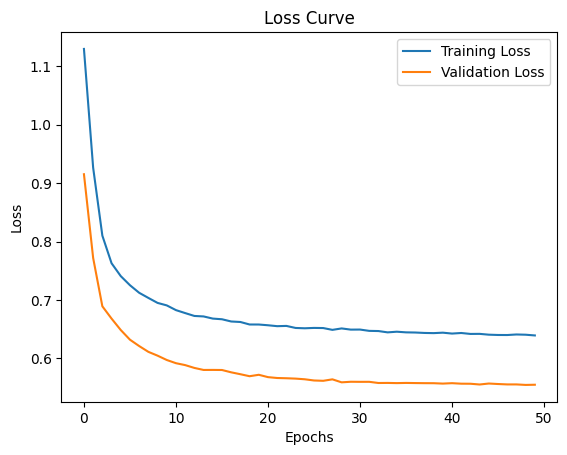

In [ ]:
# Create and train autoencoder with best hyperparameters
best_autoencoder = create_autoencoder(input_dim, best_params[0], best_params[1])
history = best_autoencoder.fit(train_data_scaled, train_data_scaled,
                               epochs=epochs,
                               batch_size=batch_size,
                               shuffle=True,
                               validation_data=(val_data_scaled, val_data_scaled))
best_autoencoder.summary()
# Plot loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()



12/12 [==============================] - 0s 2ms/step
Accuracy of anomaly detection: 0.9155313351498637


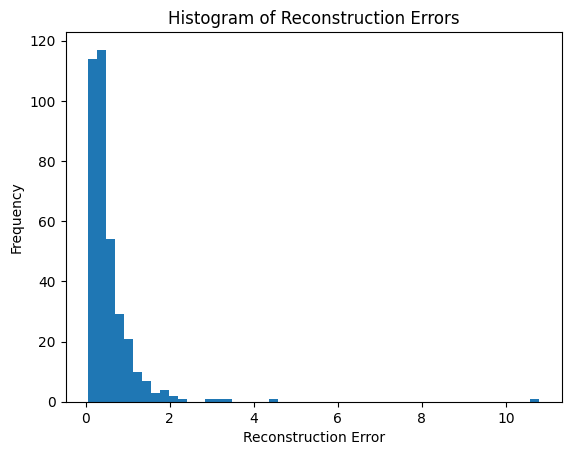

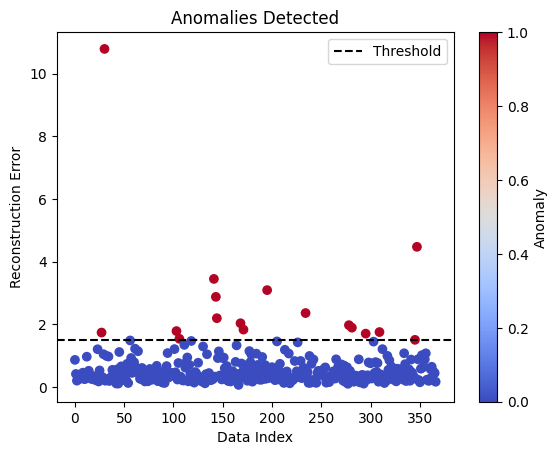

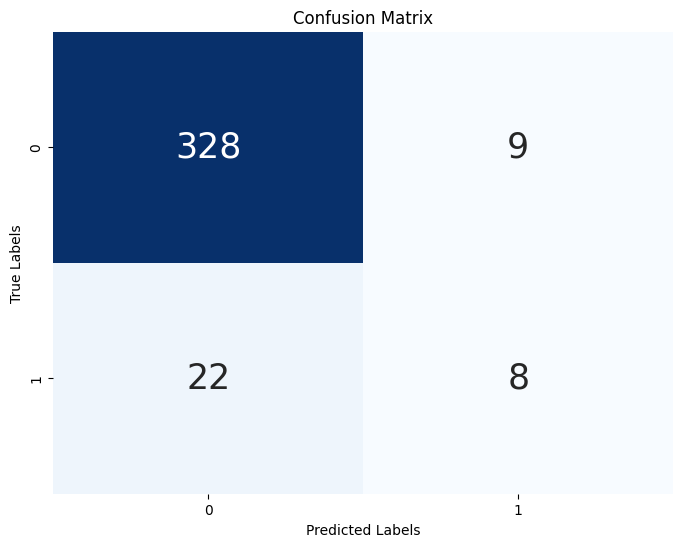

In [ ]:
# Evaluate model
test_data_predictions = best_autoencoder.predict(test_data_scaled)
mse = np.mean(np.power(test_data_scaled - test_data_predictions, 2), axis=1)

# Determine anomalies based on the reconstruction error
anomalies = mse > threshold_fixed

# Calculate accuracy of anomaly detection
accuracy = np.mean(anomalies == (test_labels == 3))
print("Accuracy of anomaly detection:", accuracy)

# Visualize reconstruction errors
plt.hist(mse, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Histogram of Reconstruction Errors")
plt.show()

# Visualize anomalies
# Visualize anomalies with threshold line
plt.scatter(range(len(mse)), mse, c=anomalies, cmap='coolwarm')
plt.axhline(y=threshold_fixed, color='black', linestyle='--', label='Threshold')
plt.xlabel("Data Index")
plt.ylabel("Reconstruction Error")
plt.title("Anomalies Detected")
plt.colorbar(label="Anomaly")
plt.legend()
plt.show()


# Calculate confusion matrix
conf_matrix = confusion_matrix((test_labels == 3).astype(int), anomalies)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize":25})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



Precision: 0.47058823529411764
Recall: 0.26666666666666666
F1-score: 0.3404255319148936
ROC AUC Score: 0.9571711177052424


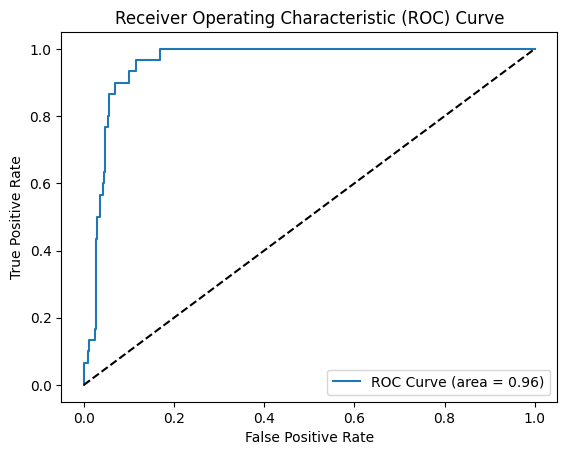

In [ ]:
# Calculate precision, recall, and F1-score for binary classification
precision = precision_score((test_labels == 3).astype(int), anomalies)
recall = recall_score((test_labels == 3).astype(int), anomalies)
f1 = f1_score((test_labels == 3).astype(int), anomalies)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Calculate ROC AUC score
roc_auc = roc_auc_score((test_labels == 3).astype(int), mse)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve((test_labels == 3).astype(int), mse)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




In [ ]:
# Calculate accuracy of anomaly detection in percentage
accuracy_percentage = np.mean(anomalies == (test_labels == 3)) * 100
print("Accuracy of anomaly detection:", accuracy_percentage, "%")

Accuracy of anomaly detection: 91.55313351498637 %


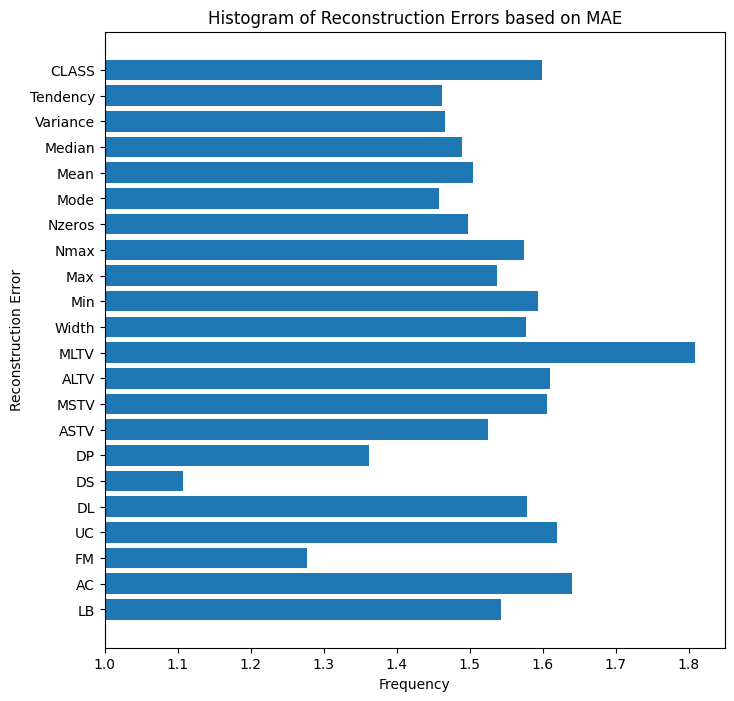

In [ ]:
import matplotlib.pyplot as plt

#MAE
AbsoluteError = abs(test_data_scaled - test_data_predictions)
mae = sum(AbsoluteError) / len(test_data_scaled)

# Set the figure size
plt.figure(figsize=(8,8))

# Plot the horizontal bar chart
plt.barh(df.columns[:-1].tolist(), mae, left=1)  # Using barh() instead of bar() and left instead of bottom

plt.xlabel("Frequency")  # Adjusted xlabel
plt.ylabel("Reconstruction Error")  # Adjusted ylabel
plt.title("Histogram of Reconstruction Errors based on MAE")

# Rotate y-axis labels by 90 degrees
#plt.yticks(rotation=90)  # Rotate y-axis labels instead of x-axis labels

plt.show()
